In [1]:
import sys
sys.executable

'c:\\Users\\carlo\\miniforge3\\envs\\dtu02452\\python.exe'

In [52]:
from pathlib import Path
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import pyedflib
from mne.time_frequency import psd_array_welch


In [53]:
data = Path(r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\rbd1.edf")
raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
raw.load_data()

raw.info["sfreq"], len(raw.ch_names), raw.ch_names[:10]

Reading 0 ... 15498751  =      0.000 ... 30270.998 secs...


C:\Users\carlo\AppData\Local\Temp\ipykernel_25000\1449954356.py:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_25000\1449954356.py:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_25000\1449954356.py:2: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)


(512.0,
 15,
 ['ROC-LOC',
  'Fp2-F4',
  'F4-C4',
  'C4-P4',
  'P4-O2',
  'C4-A1',
  'EMG1-EMG2',
  'ECG1-ECG2',
  'DX1-DX2',
  'SX1-SX2'])

In [54]:
eeg_chs  = ["Fp2-F4", "F4-C4", "C4-P4", "P4-O2", "C4-A1", "F8-T4", "F7-T3"]
ecg_chs  = ["ECG1-ECG2"]
resp_chs = ["TORACE", "ADDOME"]
eog_chs  = ["ROC-LOC"]

In [55]:
raw.get_channel_types(picks=eeg_chs[:5] + ecg_chs + resp_chs)
print("Sampling frequency:", raw.info["sfreq"])
print("Duration (s):", raw.n_times / raw.info["sfreq"])

Sampling frequency: 512.0
Duration (s): 30271.0


In [56]:
txt_path = r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\rbd1.txt"
df = pd.read_csv(txt_path, sep='\t', header=None, names=["Sleep Stage", "Position", "Time [hh:mm:ss]", "Event", "Duration[s]", "Location"], skiprows=22)
df.head()

,Sleep Stage,Position,Time [hh:mm:ss],Event,Duration[s],Location
0,W,Unknown Position,23:07:19,SLEEP-S0,30,ROC-LOC
1,W,Unknown Position,23:07:49,SLEEP-S0,30,ROC-LOC
2,W,Unknown Position,23:08:19,SLEEP-S0,30,ROC-LOC
3,W,Unknown Position,23:08:49,SLEEP-S0,30,ROC-LOC
4,W,Unknown Position,23:09:19,SLEEP-S0,30,ROC-LOC


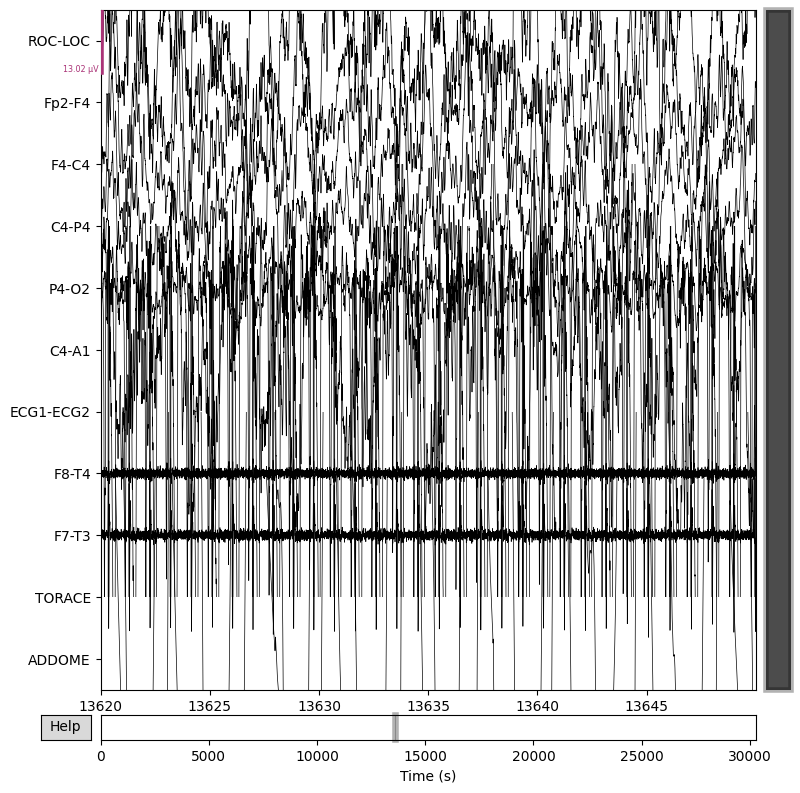

In [57]:
rem = df[df["Sleep Stage"] == "R"]
len(rem), rem.head()

epoch_len = 30.0
df["onset_s"] = np.arange(len(df)) * epoch_len

rem = df[df["Sleep Stage"] == "R"].copy()
rem_epochs = list(zip(rem["onset_s"].to_numpy(), (rem["onset_s"] + rem["Duration[s]"]).to_numpy()))

t0, t1 = rem_epochs[0]
fig = raw.plot(
    start=float(t0),
    duration=float(t1 - t0),
    picks=eeg_chs + eog_chs + ecg_chs + resp_chs,
    n_channels=len(eeg_chs + eog_chs + ecg_chs + resp_chs),
    scalings="auto",
    title="First REM epoch (30s)",
    show=True
)


In [58]:
def hrv_per_epoch(ecg_signal, rem_epochs, sf):
    rows = []
    for i, (t0, t1) in enumerate(rem_epochs):
        a, b = int(t0*sf), int(t1*sf)
        x = ecg_signal[a:b]

        try:
            signals, info = nk.ecg_process(x, sampling_rate=sf)
            # mean HR from ECG_Rate (bpm)
            hr_mean = float(np.nanmean(signals["ECG_Rate"]))

            # HRV metrics (time domain) from detected R-peaks
            hrv = nk.hrv_time(info, sampling_rate=sf).iloc[0].to_dict()

            rows.append({
                "epoch": i,
                "start_s": float(t0),
                "hr_mean_bpm": hr_mean,
                "rmssd_ms": float(hrv.get("HRV_RMSSD", np.nan)),
                "sdnn_ms": float(hrv.get("HRV_SDNN", np.nan)),
                "pnn50_pct": float(hrv.get("HRV_pNN50", np.nan)),
                "n_beats": int(len(info["ECG_R_Peaks"])) if "ECG_R_Peaks" in info else np.nan,
                "ok": True
            })
        except Exception as e:
            rows.append({"epoch": i, "start_s": float(t0), "ok": False, "error": str(e)})

    return pd.DataFrame(rows)

ecg_signal = raw.get_data(picks=ecg_chs)[0]
sf = raw.info["sfreq"]
hrv_df = hrv_per_epoch(ecg_signal, rem_epochs, sf)
hrv_df.head()


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok
0,0,13620.0,62.837176,11.885930,16.172308,0.0,31,True
1,1,13650.0,62.521115,10.598880,11.735388,0.0,31,True
2,2,13680.0,61.862937,14.629343,16.752413,0.0,31,True
3,3,13710.0,61.844937,12.756041,19.936088,0.0,31,True
4,4,13740.0,62.684902,9.826052,7.665474,0.0,31,True


In [59]:
sf = raw.info["sfreq"]
eeg_data = raw.copy().pick_channels(eeg_chs).get_data() 

bands = { "delta": (0.5, 4), "theta": (4, 8), "alpha": (8, 12), "beta":  (12, 30), "gamma": (30, 40) }

def eeg_bandpower_per_epoch(eeg_data, epochs, sf, bands):
    rows = []
    for i, (t0, t1) in enumerate(epochs):
        a, b = int(t0*sf), int(t1*sf)
        X = eeg_data[:, a:b]
        psd, freqs = psd_array_welch(X, sfreq=sf, fmin=0.5, fmax=40, verbose=False)

        row = {"epoch": i, "start_s": float(t0)}
        for name, (f1, f2) in bands.items():
            idx = (freqs >= f1) & (freqs < f2)
            bp_ch = np.trapz(psd[:, idx], freqs[idx], axis=1)  # per channel
            row[f"{name}_power"] = float(np.mean(bp_ch))       # mean across channels
        rows.append(row)

    return pd.DataFrame(rows)

eeg_df = eeg_bandpower_per_epoch(eeg_data, rem_epochs, sf, bands)
eeg_df.head()


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\carlo\AppData\Local\Temp\ipykernel_25000\2655517644.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp_ch = np.trapz(psd[:, idx], freqs[idx], axis=1)  # per channel


,epoch,start_s,delta_power,theta_power,alpha_power,beta_power,gamma_power
0,0,13620.0,0.0,3.060214e-12,1.091590e-12,1.609746e-12,1.128302e-13
1,1,13650.0,0.0,3.675917e-12,1.288538e-12,1.702728e-12,1.312743e-13
2,2,13680.0,0.0,3.178935e-12,8.927146e-13,1.923974e-12,2.042153e-13
3,3,13710.0,0.0,3.661491e-12,1.120319e-12,1.436719e-12,9.770368e-14
4,4,13740.0,0.0,2.890701e-12,1.111697e-12,1.771957e-12,1.247533e-13
